In [1]:
import random
import copy
import numpy as np
import theano as T
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%capture  --no-stderr --no-stdout --no-display
%%R

library(ggplot2)
library(reshape)
library(grid)
library(dplyr)
library(gridExtra)
library(lme4)

paper_theme_2 <- theme_light() + theme(axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14, colour="black"),
 title =element_text(size=16, face='bold'))

paper_theme_3 <- theme( axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14),
  strip.text=element_text(size=16),
  axis.line.x = element_line(colour = "black"), 
  axis.line.y = element_line(colour = "black"),
  legend.title=element_text(size=18),
  legend.text=element_text(size=16))  

  

/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Need help getting started? Try the cookbook for R:
http://www.cookbook-r.com/Graphs/

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:reshape’:

    rename


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/pyth

In [3]:
%%R --o data_resp

data_resp_loc <- read.csv("data/estimation_dot_gaze.csv", sep="\t")
data_tracker <- read.csv("data/estimation_tracker_data.csv", sep="\t")
data_tracker$trial_id <- data_tracker$trial_id - 1
data_resp_loc$trial_id <- data_resp_loc$trial_id - 1


data_resp_loc <- data_resp_loc %>%
                filter(belowX >=0) 
                #mutate(belowX=max(0.1,belowX))

trials <- (unique(data_resp_loc$trial_id))

data_tracker <- data_tracker %>%
                group_by(trial_id) %>%
                filter(trial_id %in% trials)


data_resp_loc$id <- seq.int(1, nrow(data_resp_loc))


data_resp <- data_resp_loc %>%
     #mutate(Dots_Counted=max(min(5*Dots_Shown, Dots_Counted),0.1*Dots_Shown)) %>%

      filter(gazeDist > 0 & Dots_Shown < 150 & Dots_Shown >= 10) %>%
      #mutate(gazeDist=max(0,gazeDist)) %>%

      mutate(err=Dots_Counted - Dots_Shown) %>%
      mutate(abs_err = abs(err)) %>%
      mutate(within_x = 2/(1 + exp(-0.6 -0.2*belowX)) - 1) %>%
      group_by(trial_id) %>% 
      mutate(belowX = mean(belowX)) %>%
      mutate(within_x = mean(within_x)) %>%
      mutate(nLooks=mean(nLooks)) %>%
      mutate(within_x=mean(pInGaze**0.5)) %>%

      mutate(within_x_tot = sum(within_x)) %>%
      mutate(nLooks = mean(nLooks)) %>%
      mutate(pathLength = mean(pathLength)) %>%
      mutate(medFix = mean(medFix)) %>%
      mutate(mean_dist=sum(gazeDist)/Dots_Shown) %>%
      mutate(mean_abs_err = mean(abs_err)) %>%
      mutate(pct_err=err/Dots_Shown) %>%
        mutate(abs_pct_err=abs_err/Dots_Shown) %>%

      top_n(n=1, wt=id)  %>%
      filter(abs_pct_err <= 1.) %>%
      group_by(Subject, pid)%>%
      filter(length(Subject) > 0) 


data_tracker <- data_tracker %>%
                  filter(ValidityLeft == 0 & ValidityRight == 0) %>%

                mutate(av_x = (GazePointXLeft +GazePointXRight)/2) %>%
                mutate(av_y = (GazePointYLeft +GazePointYRight)/2) %>%
                group_by(trial_id) %>%
                mutate(Time = round(max(TimeStamp)/100)/10)

data_tracker$id <- seq.int(1,nrow(data_tracker))
data_resp$Time <- as.factor(round(data_resp$Time,2))



In [4]:
data_resp = pandas2ri.ri2py(data_resp)

In [5]:
def remove_n(ls,n):
    ret = []
    for l in ls:
        l_rem = l[:n]
        ret.append(l_rem)
    return ret


subj_group = data_resp.groupby(["pid", "Subject"])
dots_shown,dots_counted,pct_area,seen,n_look=[],[],[],[],[]
for i,subj in subj_group:
    dots_shown.append(list(subj["Dots_Shown"]))
    dots_counted.append(list(subj["Dots_Counted"]))
    pct_area.append(list(subj["pctArea"] * 0.95))
    seen.append(list(subj["within_x_tot"]))
    n_look.append(list(subj["nLooks"]))

ns = [len(n) for n in seen]
min_n = min(ns)



dots_shown = remove_n(dots_shown, min_n)
dots_counted = remove_n(dots_counted, min_n)
pct_area = remove_n(pct_area, min_n)
seen = remove_n(seen, min_n)
n_look = remove_n(n_look, min_n)


dots_shown=np.array(dots_shown)
dots_counted=np.array(dots_counted)
pct_area=np.array(pct_area)
seen=np.array(seen)
n_look = np.array(n_look)
unseen = dots_shown - seen


with pm.Model() as mod:
    
    beta_grp
    
    beta = pm.HalfNormal("slope", sd=10,testval=1, shape=(len(dots_shown), 1))
    weber = pm.HalfNormal("weber",sd=1,testval=0.25, shape=(len(dots_shown), 1))
    
    guess_mean = seen * beta
    guess_sd = seen * weber
    
    lkhd = pm.Normal("lkhd", mu=guess_mean, sd=guess_sd, observed=dots_counted)
    trace = pm.sample(2500, tune=1000, cores=2, njobs=2, chains=2)
    

    
    
    

summary = pm.summary(trace)
print(summary)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [weber_log__, slope_log__]
100%|██████████| 3500/3500 [00:08<00:00, 411.54it/s]


                 mean        sd  mc_error   hpd_2.5  hpd_97.5   n_eff  \
slope__0_0   1.431628  0.090658  0.000833  1.245009  1.605344  5000.0   
slope__1_0   1.102991  0.045957  0.000476  1.015144  1.195096  5000.0   
slope__2_0   1.492909  0.073391  0.000716  1.345868  1.628984  5000.0   
slope__3_0   1.652086  0.105627  0.001017  1.446324  1.862871  5000.0   
slope__4_0   1.508798  0.073949  0.000756  1.362884  1.651928  5000.0   
slope__5_0   1.333324  0.078195  0.000770  1.178998  1.486921  5000.0   
slope__6_0   1.672552  0.142045  0.001522  1.399184  1.956997  5000.0   
slope__7_0   1.912942  0.232634  0.002699  1.453667  2.373098  5000.0   
slope__8_0   1.752086  0.107588  0.001177  1.550472  1.968743  5000.0   
slope__9_0   1.161299  0.065515  0.000696  1.029859  1.284356  5000.0   
slope__10_0  0.849065  0.036888  0.000389  0.771658  0.917946  5000.0   
slope__11_0  0.852111  0.059744  0.000582  0.730764  0.967465  5000.0   
slope__12_0  2.178057  0.129622  0.001404  1.929157

In [6]:
summary_mean = summary["mean"]

vals = {}
rownames = list(summary.index)
for i in range(len(rownames)):
    rowname = rownames[i]
    rowname = rowname[:rowname.find("__")]
    val = [summary_mean[i] for _ in range(len(range(ns[i%len(ns)])))]

    if rowname not in vals:
        vals[rowname] = copy.copy(val)
    else:
        vals[rowname] += copy.copy(val)
        
        
summary_vals = {}
for val in vals:
    summary_vals[val] = vals[val]
    
summary_vals = pd.DataFrame(summary_vals)
for i in data_resp:
    summary_vals[i] = data_resp[i]
pandas2ri.py2ri(summary_vals)


slope,weber,X,...,mean_abs_err,pct_err,abs_pct_err
1.431628,0.709989,17,...,2.000000,0.111111,0.111111
1.431628,0.709989,106,...,29.000000,-0.325843,0.325843
1.431628,0.709989,142,...,6.000000,-0.166667,0.166667
1.431628,0.709989,228,...,41.000000,-0.476744,0.476744
...,...,...,...,...,...,...
1.029207,0.357376,75624,...,1.000000,-0.047619,0.047619
1.029207,0.357376,75674,...,25.000000,-0.500000,0.500000



Call:
lm(formula = real_weber ~ pathLength, data = summary_vals)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.17278 -0.10150 -0.01430  0.07819  0.49481 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.457511   0.011597  39.450   <2e-16 ***
pathLength  0.003335   0.001713   1.948   0.0516 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1365 on 1522 degrees of freedom
Multiple R-squared:  0.002486,	Adjusted R-squared:  0.001831 
F-statistic: 3.793 on 1 and 1522 DF,  p-value: 0.05165


Call:
lm(formula = real_weber ~ medFix, data = summary_vals)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.19771 -0.09428 -0.02936  0.07472  0.50783 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.527804   0.009365  56.359  < 2e-16 ***
medFix      -0.030058   0.005314  -5.656 1.85e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



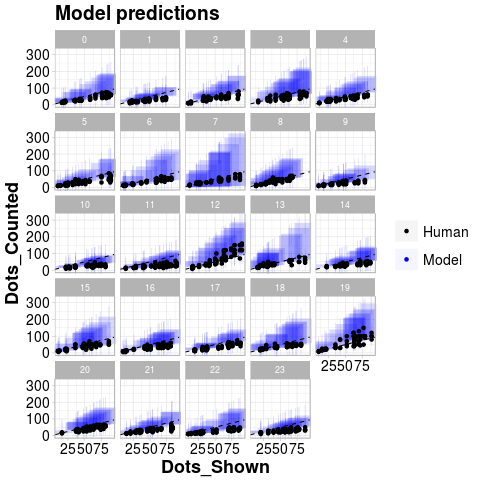

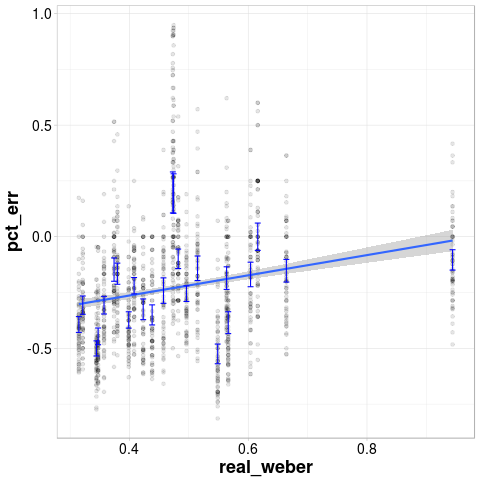

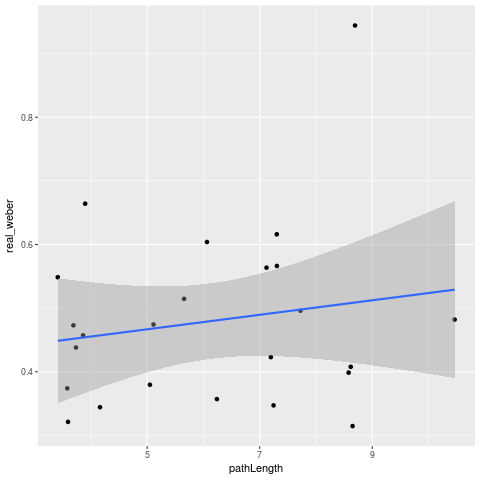

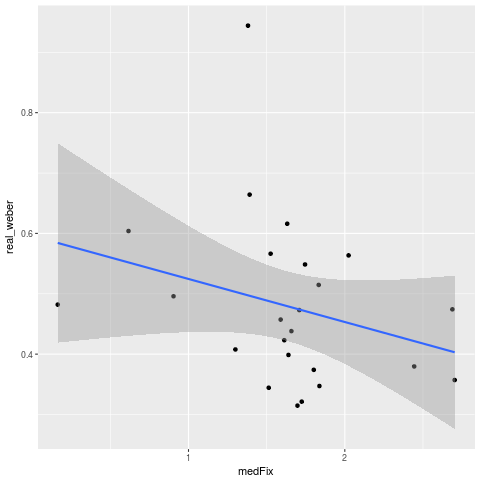

In [7]:
%%R -i summary_vals summary



#get model estimates for each participant
summary_vals <- summary_vals %>%
            mutate(pathLength=log(pathLength)) %>%
            mutate(medFix=log(medFix+1)) %>%
             mutate(unseen = (Dots_Shown - within_x_tot)) %>%
             mutate(model_guess = Dots_Shown * slope) %>%
             mutate(model_noise = Dots_Shown * weber)  %>%
             mutate(dev = (Dots_Counted - model_guess)) %>%
             mutate(abs_dev = abs(dev)) %>%

            mutate(real_weber = weber/slope) %>%
            mutate(time_num=as.numeric(as.character(Time)))
#just the mean values of parameters
#estimated in the regression

mean_reg_vals <- summary_vals %>%
            group_by(pid, Subject, Time) %>%

             mutate(pathLength =mean(pathLength)) %>%
            mutate(medFix = mean(medFix)) %>%
            mutate(real_weber = mean(real_weber)) %>%
                group_by(pid, Subject) %>%
                top_n(n=1,wt=id)

p.1 <- ggplot(data=summary_vals) +
        geom_errorbar(aes(x=Dots_Shown, ymin=model_guess - model_noise,
                                 ymax=model_guess+model_noise, color="Model"), alpha=0.04,width=1,size=10) +
        #geom_line(aes(x=Dots_Shown, y=model_guess, color="Model")) +
        geom_point(aes(x=Dots_Shown, y=Dots_Counted,color="Human")) +
        scale_color_manual(values=c("black","blue")) +
 
        facet_wrap(~pid) +
        paper_theme_2 + theme(legend.title=element_blank(), legend.text=element_text(size=14)) +
        ggtitle("Model predictions") +
        geom_abline(linetype="dashed")


p.2 <- ggplot(data=summary_vals, aes(x=real_weber, y=pct_err)) +
        geom_point(alpha=0.1, size=1.5) +
        stat_smooth(method="lm") +
        paper_theme_2 + 
        theme(legend.title=element_blank(), 
                legend.text=element_text(size=14)) +
       # stat_summary(fun.y="mean", color="blue", size=2, geom="point")
        stat_summary(fun.data="mean_cl_boot", 
                         color="blue", size=0.5, geom="errorbar", width=0.01)

p.3 <- ggplot(data=mean_reg_vals, aes(x=pathLength, y=real_weber)) +
        geom_point() + 
        stat_smooth(method="lm")

p.4 <- ggplot(data=mean_reg_vals, aes(x=medFix, y=real_weber)) +
        geom_point() + 
        stat_smooth(method="lm")
#summary(lm(data=summary_vals, pct_err ~ weber))

#summary(lm(data=mean_reg_vals, slope ~ weber))

r.1 <- summary(lm(data=mean_reg_vals, real_weber ~ pathLength))
r.2 <- summary(lm(data=summary_vals, real_weber ~ pathLength))

r.3 <- summary(lm(data=mean_reg_vals, real_weber ~ medFix))
r.4 <- summary(lm(data=summary_vals, real_weber ~ medFix))


r.5 <- summary(lm(data=summary_vals, dev ~ within_x_tot + real_weber + pathLength))
r.6 <- summary(lm(data=summary_vals, abs_dev ~  unseen)) 

#r.7 <- summary(lm(data=summary_vals, Dots_Counted ~ pathLength + within_x_tot + time_num + model_guess))
r.7 <- summary(lm(data=summary_vals, dev ~ unseen + time_num + Dots_Shown))


r.8 <- summary(lm(data=summary_vals, within_x ~ pathLength))
print(p.1)
print(p.2)
print(p.3)
print(p.4)

#print(r.1)
print(r.2)
#print(r.3)
print(r.4)
#print(r.5)
#print(r.6)
print(r.7)
#print(r.8)




     

In [9]:
%%R

mean_reg_vals <- mean_reg_vals[order(mean_reg_vals$Subject),]

for (i in mean_reg_vals$real_weber) {
    cat(i)
    cat("\n")
}

#print(mean_reg_vals)

1.806055
1.030288
0.5584055
0.5088551
0.2923978
0.6097031
0.3936221
0.6042185
0.4674553
0.6786955
0.5728409
0.5221849
0.9481231
1.070045
0.3573765
0.8446278
0.3471552
0.7099894
0.9146078
1.238531
0.4524594
1.110939
0.8502652
0.4634586
